##### Grading Feedback Cell

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [235]:
# import statements

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import numpy as np
import pandas as pd

from pyspark.sql import functions as fn, Row
from pyspark.sql.functions import col, sum, log, concat, lit
from pyspark.sql import functions as sf
from pyspark.ml import classification, feature, Pipeline, regression, evaluation
from pyspark.ml import clustering
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics

from pyspark.ml.feature import StopWordsRemover
import requests
from pyspark.ml.feature import Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF

import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.ml.stat

The following cell is used to determine if the environment is databricks or personal computer and determine the correct data file path accordingly.

In [236]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Unsupervised learning

The colleges_data_science_programs dataset contains information about dozens of "data science" programs across the US.

## Question 1: (10 pts)

This dataset contains many columns that we can use to understand how these data science programs differ from one another.

## Question 1a (5 pts)
Using get_training_filename, read the colleges_data_science_programs.csv data file into a data frame named raw_ds_programs_text_df.  Print the head of the raw_ds_programs_text_df using Pandas, and the shape using spark.

In [237]:
# Your code here

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

#read colleges_data_science_programs.csv file into a spark dataframe named raw_ds_programs_text_df
raw_ds_programs_text_df = spark.read.csv(get_training_filename('colleges_data_science_programs.csv'), 
                                         header=True, inferSchema=True)

print("Head of raw_ds_programs_text_df:", raw_ds_programs_text_df.head())
print("\n")
print("Shape of raw_ds_programs_text_df:", raw_ds_programs_text_df.count(), 
      len(raw_ds_programs_text_df.columns)) 

#get_training_filename(raw_ds_programs_text_df)
#raw_ds_programs_text_df.show()

Head of raw_ds_programs_text_df: Row(id=1, name='South Dakota State University', url='http://www.sdstate.edu/mathstat/grad/masters-in-data-science.cfm', program='Data Science', degree='Masters', country='US', state='SD', online=False, oncampus=True, department='Mathematics and Statistics', created_at='2015-01-10 04:13:13 UTC', updated_at='2015-01-10 04:13:13 UTC', university_count=1, program_size=None, courses=None, admit_reqs=None, year_founded=None, notes=None, cost=None, visualization=None, machine learning=None, business=None, databases=None, programminglanguages=None, capstone=None, mapreduce=None, part-time=None, ethics=None)


Shape of raw_ds_programs_text_df: 222 28


##### Grading Feedback Cell

## Question 1b (5 pts)
Starting with `raw_ds_programs_text_df`, create a new dataframe named`ds_programs_text_df` which simply adds a column `text` to the dataframe `raw_ds_programs_df`. This column will have the concatenation of the following columns separated by a space: `program`, `degree` and `department` (find the appropriate function in the `fn` package). <br>

An example of the `ds_programs_text_df` should give you:

```python
ds_programs_text_df.orderBy('id').first().text
```

```console
'Data Science Masters Mathematics and Statistics'
```
<br>
- Print the head of the raw_ds_programs_text_df using Pandas, and the shape using spark.<br>
- Print the text column in the first row of the ds_programs_text_df.

In [238]:
# Your code here

from pyspark.sql.functions import col, concat, lit
from pyspark.sql import functions as sf


ds_programs_text_df = raw_ds_programs_text_df.withColumn("text", 
                    sf.concat(raw_ds_programs_text_df.program, sf.lit(" "), 
                              raw_ds_programs_text_df.degree, sf.lit(" "), 
                              raw_ds_programs_text_df.department))

ds_programs_text_df.orderBy('id').first().text


#head of the raw_ds_programs_text_df using Pandas and the shape using spark
print("Head of ds_programs_text_df:", ds_programs_text_df.head())
print("\n")
print("Shape of ds_programs_text_df:", ds_programs_text_df.count(), len(raw_ds_programs_text_df.columns)) 
print("\n")


#text column in the first row of the ds_programs_text_df.
ds_programs_text_df = ds_programs_text_df.select("text","id","name","url","program","degree","country","state",
                                                 "online","oncampus","department","created_at","updated_at",
                                                 "university_count","program_size","courses","admit_reqs",
                                                 "year_founded","notes","cost","visualization","machine learning",
                                                 "business","databases","programminglanguages","capstone",
                                                 "mapreduce","part-time","ethics")
ds_programs_text_df.head()

Head of ds_programs_text_df: Row(id=1, name='South Dakota State University', url='http://www.sdstate.edu/mathstat/grad/masters-in-data-science.cfm', program='Data Science', degree='Masters', country='US', state='SD', online=False, oncampus=True, department='Mathematics and Statistics', created_at='2015-01-10 04:13:13 UTC', updated_at='2015-01-10 04:13:13 UTC', university_count=1, program_size=None, courses=None, admit_reqs=None, year_founded=None, notes=None, cost=None, visualization=None, machine learning=None, business=None, databases=None, programminglanguages=None, capstone=None, mapreduce=None, part-time=None, ethics=None, text='Data Science Masters Mathematics and Statistics')


Shape of ds_programs_text_df: 222 28




Row(text='Data Science Masters Mathematics and Statistics', id=1, name='South Dakota State University', url='http://www.sdstate.edu/mathstat/grad/masters-in-data-science.cfm', program='Data Science', degree='Masters', country='US', state='SD', online=False, oncampus=True, department='Mathematics and Statistics', created_at='2015-01-10 04:13:13 UTC', updated_at='2015-01-10 04:13:13 UTC', university_count=1, program_size=None, courses=None, admit_reqs=None, year_founded=None, notes=None, cost=None, visualization=None, machine learning=None, business=None, databases=None, programminglanguages=None, capstone=None, mapreduce=None, part-time=None, ethics=None)

##### Grading Feedback Cell

# Question 2: (10 pts) 

## Question 2a (5 pts)
Create a pipeline named `pipe_features` that creates a new dataframe `ds_features_df`.  The pipe_features pipeline adds a column `features` to `ds_programs_text_df` that contains the `tfidf` of the `text` column.  Print the head of ds_features_df using Pandas and print the shape using spark.

In [239]:
from pyspark.ml.feature import StopWordsRemover

colNames = ['text']
ds_programs_text_df = ds_programs_text_df.na.fill(" ", colNames)
#ds_programs_text_df.select("text").show()

import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

tokenizer = feature.RegexTokenizer(minTokenLength=2)\
  .setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("words")

sw_filter = feature.StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

cv = CountVectorizer(inputCol='filtered', outputCol='tf')

idf = IDF().\
    setInputCol("tf").\
    setOutputCol("features")

pipe_features = Pipeline(stages=[tokenizer,sw_filter,cv,idf]).fit(ds_programs_text_df)
lv=len(pipe_features.stages[2].vocabulary)
#print(lv)
ds_features_df = pipe_features.transform(ds_programs_text_df)
ds_features_df = ds_features_df.drop('words')
ds_features_df = ds_features_df.drop('filtered')
ds_features_df = ds_features_df.drop('tf')
ds_features_dfCOPY = ds_features_df
print(ds_features_df.head(),"\n")
print(ds_features_df.count(), len(ds_features_df.columns))

Row(text='Data Science Masters Mathematics and Statistics', id=1, name='South Dakota State University', url='http://www.sdstate.edu/mathstat/grad/masters-in-data-science.cfm', program='Data Science', degree='Masters', country='US', state='SD', online=False, oncampus=True, department='Mathematics and Statistics', created_at='2015-01-10 04:13:13 UTC', updated_at='2015-01-10 04:13:13 UTC', university_count=1, program_size=None, courses=None, admit_reqs=None, year_founded=None, notes=None, cost=None, visualization=None, machine learning=None, business=None, databases=None, programminglanguages=None, capstone=None, mapreduce=None, part-time=None, ethics=None, features=SparseVector(74, {0: 0.9074, 2: 1.2175, 4: 1.557, 5: 2.6346, 24: 3.6154})) 

222 30


In [240]:
# Create ds_programs_text_df here

from pyspark.ml import Pipeline


colNames = ["text"]
ds_programs_text_df = ds_programs_text_df.na.fill(" ", colNames)
ds_programs_text_df.select("text").show()


import requests
stop_words = requests.get("http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words").text.split()


from pyspark.ml.feature import Tokenizer
tokenizer = feature.RegexTokenizer(minTokenLength = 2).setGaps(False).setPattern("\\p{L}+")\
  .setInputCol("text").setOutputCol("words")


from pyspark.ml.feature import StopWordsRemover
sw_filter = feature.StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")


from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol = "filtered", outputCol = "tf")

from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol("tf").\
    setOutputCol("features")


pipe_features = Pipeline(stages = [tokenizer,sw_filter,cv,idf]).fit(ds_programs_text_df)
lv  = len(pipe_features.stages[2].vocabulary)
ds_features_df = pipe_features.transform(ds_programs_text_df)
ds_features_df = ds_features_df.drop("words")
ds_features_df = ds_features_df.drop("filtered")
ds_features_df = ds_features_df.drop("tf")


print("Head of ds_features_df:", ds_features_df.head())
print("\n")
print("Shape of ds_features_df:", ds_features_df.count(), len(ds_features_df.columns))

+--------------------+
|                text|
+--------------------+
|Data Science Mast...|
|Analytics Masters...|
|Data Science Mast...|
|Business Intellig...|
|Advanced Computer...|
|Business Data Ana...|
|Data Mining Maste...|
|                    |
|Business Analytic...|
|Data Analytics Ba...|
|Data Science Bach...|
|Data Analysis and...|
|Data Science Mast...|
|                    |
|Information Quali...|
|                    |
|Business Analytic...|
|Big Data Analytic...|
|Data Science Mast...|
|Data Analysis Cer...|
+--------------------+
only showing top 20 rows

Head of ds_features_df: Row(text='Data Science Masters Mathematics and Statistics', id=1, name='South Dakota State University', url='http://www.sdstate.edu/mathstat/grad/masters-in-data-science.cfm', program='Data Science', degree='Masters', country='US', state='SD', online=False, oncampus=True, department='Mathematics and Statistics', created_at='2015-01-10 04:13:13 UTC', updated_at='2015-01-10 04:13:13 UTC', universi

##### Grading Feedback Cell

## Question 2b (5 pts)
Create a pipeline model `pipe_pca` that computes the two first principal components of the `features` column as computed by `pipe_features` and creates a column named `scores`. Use that pipeline to create a dataframe `ds_features_df` with the columns `id`, `name`, `url`, and `scores`.

In [241]:
# create ds_features_df here

from pyspark.ml import clustering


pipe_pca = Pipeline(stages = [feature.StandardScaler(withMean = True, inputCol = "features", 
                                                     outputCol = "zfeatures"),feature.PCA(k = 10, 
                                                                                          inputCol = "zfeatures", 
                                                                                          outputCol = "scores")])\
.fit(ds_features_df)


pipe_pca.transform(ds_features_df).select("id", "name", "url", "scores").show()

+---+--------------------+--------------------+--------------------+
| id|                name|                 url|              scores|
+---+--------------------+--------------------+--------------------+
|  1|South Dakota Stat...|http://www.sdstat...|[0.44881393014400...|
|  2|Dakota State Univ...|http://www.dsu.ed...|[0.04058844980359...|
|  3|    Lewis University|http://www.lewisu...|[0.43123911934213...|
|  4|Saint Joseph's Un...|http://online.sju...|[-2.0129279356335...|
|  5| University Of Leeds|http://www.engine...|[0.33037145178837...|
|  6|Arizona State Uni...|http://wpcarey.as...|[0.01114555780571...|
|  7|University Of Cen...|http://dms.stat.u...|[0.24280458521947...|
|  8|Hong Kong Univers...|http://www.rmbi.u...|[0.18101923993270...|
|  9|University of Tex...|https://jindal.ut...|[-0.0224643447871...|
| 10|The Ohio State Un...|https://data-anal...|[0.28773729250365...|
| 11|University of Roc...|http://www.roches...|[0.52787043598141...|
| 12|         TU Dortmund|http://w

##### Grading Feedback Cell

# Question 3: (10 pts)

Create a scatter plot with the x axis containing the first principal component (loading) and the y axis containing the second principal component (loading) of `ds_features_df`

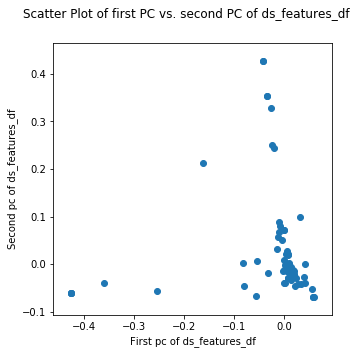

In [242]:
# Your code here

import matplotlib.pyplot as plt

loading = pipe_pca.stages[-1]
pc1 = loading.pc.toArray()[:, 0].tolist()
pc2 = loading.pc.toArray()[:, 1].tolist()

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
ax.scatter(pc1, pc2)

fig.suptitle("Scatter Plot of first PC vs. second PC of ds_features_df ")
ax.set_xlabel("First pc of ds_features_df")
ax.set_ylabel("Second pc of ds_features_df")
display()

##### Grading Feedback Cell

# Question 4 (10 pts)

Create two Pandas dataframes `pc1_pd` and `pc2_pd` with the columns `word` and `abs_loading` that contain the top 5 words and absolute loadings for the principal components 1 and 2, respetively.  Print both dataframes. Interpret the loadings.

In [244]:
# your code here (5 pts)

import numpy as np
import pandas as pd

vocabulary = pipe_features.stages[1].vocabulary


for i in range(len(pc1)):
 pc1[i] = abs(pc1[i])
for i in range(len(pc2)):
 pc2[i] = abs(pc2[i])


pc1_pd = pd.DataFrame([vocabulary, pc1]).T.rename(columns = {0: "word", 
                                                             1: "abs_loading"})
pc1_pd.sort_values("abs_loading",ascending = False).\
    apply({"word": lambda x: x, "abs_loading": np.abs}, axis = 0).\
    head(5)

AttributeError: 'StopWordsRemover' object has no attribute 'vocabulary'

In [245]:
pc2_pd = pd.DataFrame([vocabulary, pc2]).T.rename(columns = {0: "word", 
                                                          1: "abs_loading"})
pc2_pd.sort_values("abs_loading",ascending = False).\
                    apply({"word": lambda x: x, "abs_loading": np.abs}, axis = 0).\
                    head(5)

,word,abs_loading
47,development,0.427607
41,center,0.427607
59,sets,0.352921
73,massive,0.352921
18,professional,0.329003


##### Grading Feedback Cell

Your interpretation here (5 pts): 

We have taken absolute values of the loadings and hence large values of the loadings indicate that a variable has a strong effect on that principal component. Also, positive loadings indicate a variable and principal component are positively correlated and if the values are negative, it means they are negative correlated.

##### Grading Feedback Cell

# Question 5: (10 pts)

Create a new pipeline for PCA called `pipe_pca2` where you fit 50 principal components. Extract the `PCAModel` from the stages of this pipeline, and assign to a variable named `explainedVariance` which represents the variance explained by components of the model. Finally, assign to a variable named `best_k` the value $k$ such that ($k+1$)-th component is not able to explain more than 0.01 variance. You can use a for-loop to find such best k.  The value best_k should be be 0 based - in other words present best_k assuming that you started counting at 0.

In [246]:
# your code here

pipe_pca2 = Pipeline(stages = [feature.StandardScaler(withMean = True, withStd = False, 
                                                      inputCol = "features", outputCol = "zfeatures"),
                               feature.PCA(k = 50, inputCol = "zfeatures", outputCol = "scores")
]).fit(ds_features_df)


explainedVariance = pipe_pca2.stages[-1].explainedVariance
for i in range(0, len(explainedVariance)):
  if explainedVariance[i] < 0.01:
    best_k = i - 1
    break
    
best_k

26

##### Grading Feedback Cell

# Question 6: (10 pts)

Create a new pipeline for PCA called pipe_pca3 (similar to pipe_pca2 above) where you fit the maximum possible number of principal components for this dataset. Create a scree plot and a plot of cumulative variance explained.

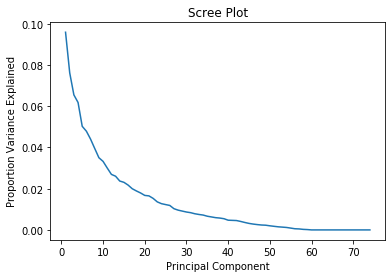

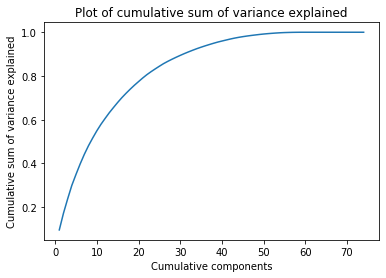

In [249]:
# your code here

pipe_pca3 = Pipeline(stages = [
    feature.VectorAssembler(inputCols = ["features"], outputCol = "xfeatures"),
    feature.StandardScaler(withMean = True,withStd = False, inputCol = "xfeatures", outputCol = "zfeatures"),
    feature.PCA(k = lv, inputCol = "zfeatures", outputCol = "scores")
]).fit(ds_features_df)


plt.figure()
explained_var = pipe_pca3.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var) + 1), explained_var)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")
display()


cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var) + 1), cum_sum)
plt.title("Plot of cumulative sum of variance explained")
plt.xlabel("Cumulative components")
plt.ylabel("Cumulative sum of variance explained")
display()

##### Grading Feedback Cell

# Question 7: (10 pts)
Create a pipeline named pipe_pca4 (similar to pipe_pca3 above) that computes the first 2 principal components.  Add a kmeans objects to the end of pipe_pca4 and compute kmeans with k = 5.  Create a scatter plot PC2 vs. PC1 where each scatter dot is colored by the cluster assignment.  Include a plot legend.

Length of pc1: 222 

Length of pc2: 222 

Length of kmeans_feat: 222


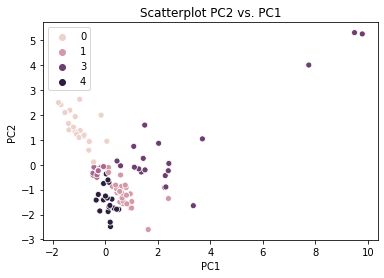

In [253]:
# your code here

from pyspark.ml import clustering


pipe_pca4 = Pipeline(stages = [
    feature.VectorAssembler(inputCols = ["features"], outputCol = "xfeatures"),
    feature.StandardScaler(withMean = True, withStd = False, inputCol = "xfeatures", outputCol = "zfeatures"),
    feature.PCA(k = 2, inputCol = "zfeatures", outputCol = "scores")
]).fit(ds_features_df)


norm = feature.Normalizer(inputCol = "scores", outputCol = "norm_tfidf", p = 2.0)
kmeans = clustering.KMeans(k = 5, featuresCol = "norm_tfidf", predictionCol = "kmeans_feat")


pipeline = Pipeline(stages = [pipe_pca4,norm,kmeans]).fit(ds_features_df)
df = pipeline.transform(ds_features_df)


import pandas as pd
import seaborn as sns


pc1 = df.select("scores").rdd.map(lambda x:x["scores"][0]).collect()
pc2 = df.select("scores").rdd.map(lambda x:x["scores"][1]).collect()
kmeans_feat = df.select("kmeans_feat").rdd.map(lambda x:x["kmeans_feat"]).collect()
print("Length of pc1:", len(pc1),"\n")
print("Length of pc2:", len(pc2),"\n")
print("Length of kmeans_feat:", len(kmeans_feat))

sns.scatterplot(x = pc1, y = pc2, hue = kmeans_feat).set(title = "Scatterplot PC2 vs. PC1", 
                                                         xlabel = "PC1", ylabel = "PC2")

display()

##### Grading Feedback Cell

# Question 8: (10 pts)
Starting with pipe_pca2, transform the pipeline and save the resulting dataframe to a variable named `pca_fun`.  Extract the output from the standard scaler column from the first row of pca_fun and store in a variable called `z`. Manually compute 10 PCA scores by projecting z onto the first 10 loading vectors. Save the 10 projected pca scores in a varialbe called `projection`.  Extract the first 10 PCA scores from the first row of pca_fun and save them in a variable named `model_scores`.  Print `projection` and `model_scores`.  Compare `projection` to `model_scores` and explain why they are the same or different. 

In [255]:
# your code here (5 pts)

loadings = pipe_pca2.stages[-1].pc.toArray()


pca_fun = pipe_pca2.transform(ds_features_df)


z = pca_fun.select("zfeatures").rdd.map(lambda x:x["zfeatures"]).first()


projection = z.dot(loadings[:,0:10])
print(projection)


model_scores = pca_fun.select("scores").first()["scores"][0:10]
print(model_scores)

[ 0.32993785 -1.74035675 -0.37987178  0.61158753 -0.78136264  2.07099227
 -1.00953816  0.10879115 -0.22527308 -0.04399573]
[ 0.32993785 -1.74035675 -0.37987178  0.61158753 -0.78136264  2.07099227
 -1.00953816  0.10879115 -0.22527308 -0.04399573]


##### Grading Feedback Cell

Your explanation here (5 pts): 

The projection and the model_score is the same because projection is the same computation as what we did by tranforming the pipe_pca2. While model_scores is the machine's way of computing the score, projection is the manual way of computing the score.

##### Grading Feedback Cell

# Question 9: (10 pts)
Using PCA loading vectors, perform an inverse transform on the `projection` variable and store the result in a variable named inverse.  Print `inverse` and the original `z` data.  Explain why the inverse data is the same as `z` (or really close to `z`), or why it is different than `z`.  

In [260]:
# your code here (5 pts)

inverse = loadings[:,:10].dot(projection)


print("inverse shape:", inverse.shape,"\n")
print("inverse:", inverse,"\n")
print(z)

inverse shape: (74,) 

inverse: [ 1.71601974e-01 -6.30166202e-01  7.59332549e-01 -1.40339396e-01
  9.17673024e-01  2.26670189e+00 -3.46613009e-01  2.13238557e-01
  2.79926882e-01 -1.61077030e-01  9.64084816e-02  2.52002137e-01
 -3.22584880e-01  2.51118846e-01 -1.48384828e-01  2.52488719e-01
  3.18509669e-01 -2.27116157e-01 -8.91220952e-02  2.24371938e-01
 -3.19502899e-01 -5.31949167e-02 -2.45978907e-03  3.16573712e-01
  6.04945618e-01 -1.09978165e-01  1.07181173e-01  7.65625855e-01
 -5.77207028e-02 -1.11922182e-01 -4.16611269e-02 -1.11922182e-01
 -8.96164881e-02  3.54786267e-03 -4.94591758e-02  2.29526034e-01
  2.48984398e-02 -5.68815262e-02  3.49783595e-01 -4.19806972e-02
 -8.52702851e-04  8.23411429e-04 -3.93769540e-01  6.30576301e-02
 -8.04143183e-02 -4.75854936e-02  2.29526034e-01  8.23411429e-04
 -2.74538549e-02 -1.31705789e-02  7.29307491e-02 -1.64393386e-02
  2.85782304e-01 -7.26721579e-02 -1.95674902e-02 -5.15898582e-02
  1.49644680e-03 -7.51119700e-02 -3.08783679e-02 -5.955466

##### Grading Feedback Cell

Your explanation here (5 pts):

The original data is nearly close to the inverse transform since PCA is basically a linear transformation of the data, fundamentally, it's just a rotation. And rotations are invertible transformations.

##### Grading Feedbck Cell

# Question 10: (10 pts)

Think about the cumulative variance and the scree plot from the question above.  If you were building a machine learning model, how many principal components would you pick for your model.  Explain why.  

Your Answer Here:

The scree plot shows how much variance is captured by each PC component. In the scree plot, maximum number of variation is explained by the first 40 components and even in the cumulative variance plot,the cumulative sum of the plot doesn't increase much after 40 PC. 
I think a model around 40 PCs would be efficient since it would cover most of the variations and give less error.

##### Grading Feedback Cell